# Creación de un Modelo de Clasificación para Predecir Problemas en Procesos de un Servidor

## Liberias

In [1]:
# Procesamiento de Datos
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd 
import numpy as np 

# Graficas
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib 
matplotlib.style.use('ggplot')

#Auxiliares
import warnings
warnings.filterwarnings("ignore")

#Modelos
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

#Metricas
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

## Lectura de data

Se carga el archivo CSV proporcionado para preparar los datos y proceder con la creación del modelo.

In [2]:
df = pd.read_csv(r'./data/datos_procesos.csv', sep='|')
df.head()

,ID_Proceso,Uso_CPU,Uso_Memoria,Numero_Hilos,Tiempo_Ejecucion,Numero_Errores,Tipo_Proceso,Estado
0,1,37.454012,59.515562,16,8.184879,3,Aplicación,0
1,2,95.071431,36.471714,18,76.195256,8,Aplicación,0
2,3,73.199394,0.537562,21,46.991138,3,Aplicación,0
3,4,59.865848,56.108773,28,87.884325,4,Aplicación,0
4,5,15.601864,89.657041,39,4.622599,1,Sistema,0


Se elimina el campo ID_Proceso, ya que no aporta información relevante para nuestro problema. Posteriormente, se verifica la existencia de registros duplicados en los datos y, en caso de encontrarlos, se procede a eliminarlos.

In [3]:
df = df.drop('ID_Proceso', axis= 1)
df = df.drop_duplicates()

## Entendimiento de los Datos

Se realiza una revisión de las columnas relevantes del problema y se analiza la cantidad de valores nulos presentes en los datos.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Uso_CPU           1000000 non-null  float64
 1   Uso_Memoria       1000000 non-null  float64
 2   Numero_Hilos      1000000 non-null  int64  
 3   Tiempo_Ejecucion  1000000 non-null  float64
 4   Numero_Errores    1000000 non-null  int64  
 5   Tipo_Proceso      1000000 non-null  object 
 6   Estado            1000000 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 53.4+ MB


Se verifica que no existen valores nulos en los datos. Sin embargo, se identifica una columna de tipo categórica, por lo que se aplica la clase OneHotEncoder() para convertir las categorías en variables binarias.

In [5]:
df.describe()

,Uso_CPU,Uso_Memoria,Numero_Hilos,Tiempo_Ejecucion,Numero_Errores,Estado
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,50.033449,49.947866,25.030640,50.043250,5.003483,0.064631
std,28.859113,28.851514,14.150159,28.829111,2.237005,0.245874
min,0.000052,0.000038,1.000000,0.100083,0.000000,0.000000
25%,25.034021,24.999623,13.000000,25.074789,3.000000,0.000000
50%,50.055597,49.895350,25.000000,50.040186,5.000000,0.000000
75%,75.009673,74.924148,37.000000,75.030119,6.000000,0.000000
max,99.999831,99.999938,49.000000,99.999992,19.000000,1.000000


In [6]:
df.describe(include = 'object')

,Tipo_Proceso
count,1000000
unique,3
top,Servicio
freq,334085


In [7]:
Counter(df['Estado'])

Counter({0: 935369, 1: 64631})

Primero se revisa el desbalanceo en los datos, y debido a este desbalance, se reduce la cantidad de registros correspondientes al Estado = 0 para equilibrar la distribución. A continuación, se realiza una revisión de la correlación entre las variables y se analiza la distribución de los datos para identificar patrones y relaciones importantes.

[]

<Figure size 1500x1000 with 0 Axes>

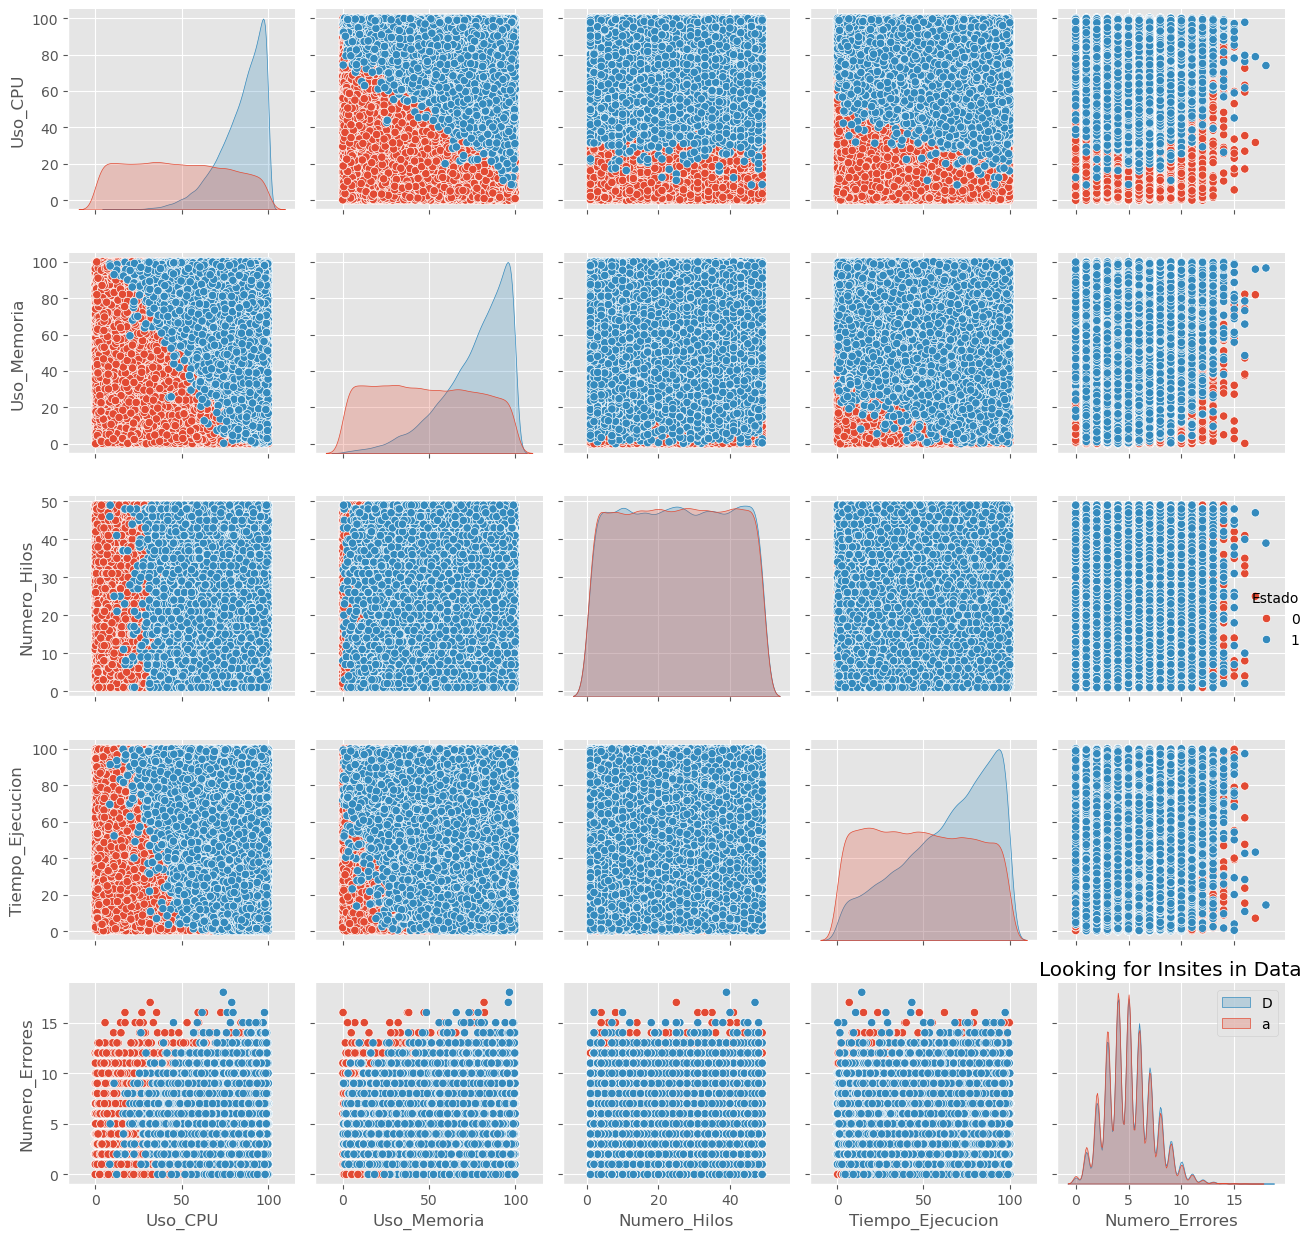

In [8]:
plt.figure(figsize=(15,10))
sns.pairplot(df.groupby('Estado').sample(50000), hue= 'Estado')
plt.title("Looking for Insites in Data")
plt.legend("Data Computadores")
plt.tight_layout()
plt.plot()

Se decide eliminar los campos numero_hilos y numero_errores, ya que no proporcionan segmentación relevante en relación con nuestra variable objetivo, Estado.

In [9]:
df = df.drop(['Numero_Hilos', 'Numero_Errores'], axis= 1)

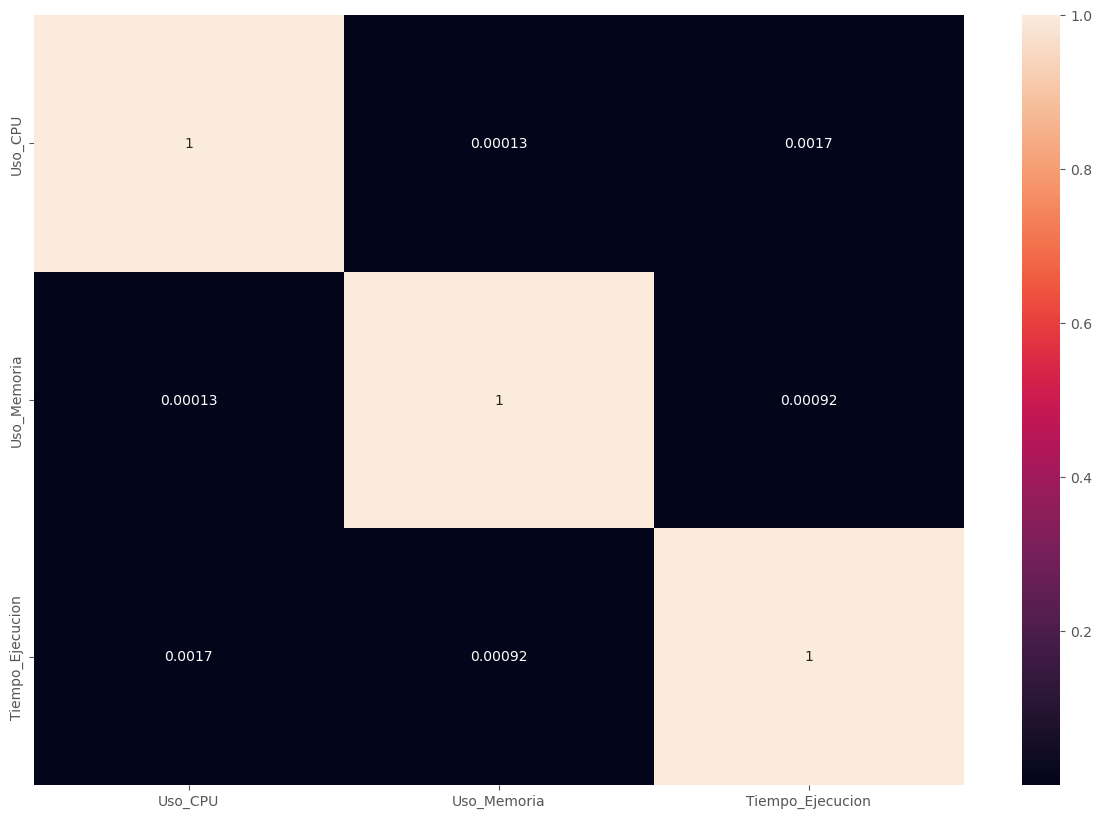

In [10]:
plt.figure(figsize=(15,10))
sns.heatmap(data = df[['Uso_CPU','Uso_Memoria','Tiempo_Ejecucion']].corr(), annot = True,)
plt.show()

No se observa ninguna correlación adicional relevante en los datos, por lo que se procede a la preparación de los mismos para el siguiente paso.

## Preparacion de los datos

Luego de revisar y analizar los tipos de datos disponibles, y eliminar aquellos que no aportan información relevante, es necesario organizar los campos para el modelo. En este caso, se aplica un OneHotEncoder al campo 'Tipo de Proceso', ya que es un campo categórico y no numérico. Además, se procede a escalar los datos utilizando un MinMaxScaler para ajustar los valores a rangos similares.

### OneHot Encoder

In [11]:
X_num = df.select_dtypes(exclude='object')
X_cat = df.select_dtypes(include='object')

encoder = OneHotEncoder(sparse_output=False,handle_unknown='error')
X_encoded = encoder.fit_transform(X_cat)
X_encoded

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [12]:
categorical_columns = [f'{col}_{cat}' for i, col in enumerate(X_cat.columns) for cat in encoder.categories_[i]]
categorical_columns

['Tipo_Proceso_Aplicación', 'Tipo_Proceso_Servicio', 'Tipo_Proceso_Sistema']

In [13]:
one_hot_features = pd.DataFrame(X_encoded, columns=categorical_columns,dtype=int)
one_hot_features

,Tipo_Proceso_Aplicación,Tipo_Proceso_Servicio,Tipo_Proceso_Sistema
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,0,0,1
...,...,...,...
999995,0,1,0
999996,0,0,1
999997,0,0,1
999998,0,1,0


In [14]:
df = (X_num.join(one_hot_features))[['Uso_CPU','Uso_Memoria','Tiempo_Ejecucion','Tipo_Proceso_Aplicación','Tipo_Proceso_Servicio','Tipo_Proceso_Sistema','Estado']]
df.head()

,Uso_CPU,Uso_Memoria,Tiempo_Ejecucion,Tipo_Proceso_Aplicación,Tipo_Proceso_Servicio,Tipo_Proceso_Sistema,Estado
0,37.454012,59.515562,8.184879,1,0,0,0
1,95.071431,36.471714,76.195256,1,0,0,0
2,73.199394,0.537562,46.991138,1,0,0,0
3,59.865848,56.108773,87.884325,1,0,0,0
4,15.601864,89.657041,4.622599,0,0,1,0


### Min-Max Scaler

Se utiliza el escalado con MinMaxScaler para normalizar todos los datos, llevándolos a un rango de [0,1].

In [15]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled.head()

,Uso_CPU,Uso_Memoria,Tiempo_Ejecucion,Tipo_Proceso_Aplicación,Tipo_Proceso_Servicio,Tipo_Proceso_Sistema,Estado
0,0.374540,0.595156,0.080929,1.0,0.0,0.0,0.0
1,0.950716,0.364717,0.761714,1.0,0.0,0.0,0.0
2,0.731995,0.005375,0.469380,1.0,0.0,0.0,0.0
3,0.598659,0.561088,0.878722,1.0,0.0,0.0,0.0
4,0.156018,0.896571,0.045270,0.0,0.0,1.0,0.0


# Sets de Datos

Una vez que los datos han sido procesados y están listos para entrenar un modelo, es necesario balancearlos debido a la desproporción existente entre las dos clases de clasificación. Posteriormente, se dividen en conjuntos de datos para el entrenamiento y la validación (prueba).

In [16]:
X = df.drop('Estado', axis = 1)
y = df['Estado']

In [17]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
Counter(y_res)

Counter({0: 64631, 1: 64631})

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X_res,y_res ,random_state=123, stratify=y_res)

## Modelamiento

Con los datos ya procesados y balanceados, y después de haberlos dividido en conjuntos de entrenamiento y prueba, se procederá a entrenar varios modelos utilizando GridSearchCV. Esta técnica se empleará para encontrar los mejores hiperparámetros para cada modelo, optimizando su rendimiento. Los modelos que se evaluarán incluyen:

* Regresión Logística (LogisticRegression)
* Árbol de Decisión (DecisionTreeClassifier)
* K-Vecinos más Cercanos (KNeighborsClassifier)
* XGBoost (XGBClassifier)

GridSearchCV realizará una búsqueda exhaustiva a través de un rango de valores para cada parámetro, seleccionando el que ofrezca el mejor desempeño en función de la métrica de evaluación definida.

In [19]:
models = {
    "Logistic Regression": LogisticRegression(random_state = 42),
    "Decision Tree": DecisionTreeClassifier(random_state = 42),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(random_state = 42),
}

Se organizan los parámetros para cada modelo, definiendo un conjunto de valores a evaluar durante la búsqueda con GridSearchCV. Estos parámetros se seleccionan para optimizar el rendimiento de cada modelo y cubrir un rango adecuado de configuraciones. A continuación, se detallan los parámetros que se ajustarán para cada modelo.

In [20]:
param_range = [1, 2, 3, 4, 5, 6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [50, 100, 150, 200]
learning_rates = [.1, .2, .3]

lr_param_grid = [{
    'penalty': ['l1', 'l2'],
    'C': param_range_fl,
    'solver': ['liblinear']
}]

dt_param_grid = [{
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': param_range,
    'max_depth': param_range[2:],
    'min_samples_split': param_range[1:]
}]

knn_param_grid = [{
    'n_neighbors': param_range,
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
}]

svm_param_grid = [{
    'kernel': ['linear', 'rbf'], 
    'C': param_range_fl
}]

xgb_param_grid = [{
    'learning_rate': learning_rates,
    'max_depth': param_range,
    'min_child_weight': param_range[:2],
    'subsample': param_range_fl,
    'n_estimators': n_estimators
}]


In [21]:
lr_grid_search = GridSearchCV(estimator=models['Logistic Regression'],param_grid=lr_param_grid,scoring='roc_auc',cv=3,verbose = 3)
dt_grid_search = GridSearchCV(estimator=models['Decision Tree'],param_grid=dt_param_grid,scoring='roc_auc',cv=3,verbose = 3)
knn_grid_search = GridSearchCV(estimator=models['KNN'],param_grid=knn_param_grid,scoring='roc_auc',cv=3,verbose = 3)
xgb_grid_search = GridSearchCV(estimator=models['XGBoost'],param_grid=xgb_param_grid,scoring='roc_auc',cv=3,verbose = 3)

A continuacion se entrenan cada uno de los modelos

In [22]:
grids =  [
    lr_grid_search, dt_grid_search, 
    knn_grid_search, xgb_grid_search
]

for model in grids:
    print(model.get_params()['estimator'])
    model.fit(X_train,y_train)

LogisticRegression(random_state=42)
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END C=1.0, penalty=l1, solver=liblinear;, score=0.970 total time=   0.2s
[CV 2/3] END C=1.0, penalty=l1, solver=liblinear;, score=0.972 total time=   0.2s
[CV 3/3] END C=1.0, penalty=l1, solver=liblinear;, score=0.972 total time=   0.2s
[CV 1/3] END C=1.0, penalty=l2, solver=liblinear;, score=0.970 total time=   0.0s
[CV 2/3] END C=1.0, penalty=l2, solver=liblinear;, score=0.972 total time=   0.0s
[CV 3/3] END C=1.0, penalty=l2, solver=liblinear;, score=0.972 total time=   0.0s
[CV 1/3] END C=0.5, penalty=l1, solver=liblinear;, score=0.970 total time=   0.1s
[CV 2/3] END C=0.5, penalty=l1, solver=liblinear;, score=0.972 total time=   0.2s
[CV 3/3] END C=0.5, penalty=l1, solver=liblinear;, score=0.972 total time=   0.1s
[CV 1/3] END C=0.5, penalty=l2, solver=liblinear;, score=0.970 total time=   0.0s
[CV 2/3] END C=0.5, penalty=l2, solver=liblinear;, score=0.972 total time=   0.0s
[C

In [23]:
grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 2: 'K-Nearest Neighbors', 3: 'XGBoost'}

for i, model in enumerate(grids):
    print('{} Test Accuracy: {}'.format(grid_dict[i],model.score(X_test,y_test)))
    print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))

Logistic Regression Test Accuracy: 0.9703697891968867
Logistic Regression Best Params: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Decision Trees Test Accuracy: 0.953648300072923
Decision Trees Best Params: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2}
K-Nearest Neighbors Test Accuracy: 0.9454355048267709
K-Nearest Neighbors Best Params: {'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}
XGBoost Test Accuracy: 0.9700472934518505
XGBoost Best Params: {'learning_rate': 0.2, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.5}


Luego de realizar el proceso de GridSearchCV para cada modelo, se determina que el mejor modelo es el de Regresión Logística, con los siguientes parámetros optimizados: **{'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}**. Para validar el rendimiento final del modelo, se utilizarán la matriz de confusión y la curva ROC.

In [24]:
pred = lr_grid_search.predict(X_test)

In [27]:
import pickle

with open("model.pkl",'wb') as f:
    pickle.dump(lr_grid_search, f)

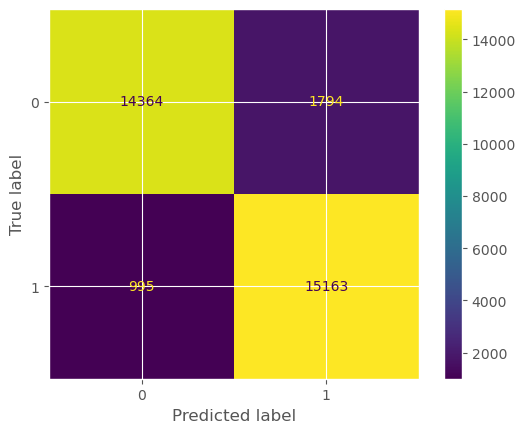

In [25]:
ConfusionMatrixDisplay(confusion_matrix(y_test, pred), display_labels=[0,1],).plot()
plt.show()

La matriz de confusión muestra que la mayoría de las predicciones se realizan correctamente, lo que indica un buen desempeño del modelo al clasificar las instancias de manera precisa.

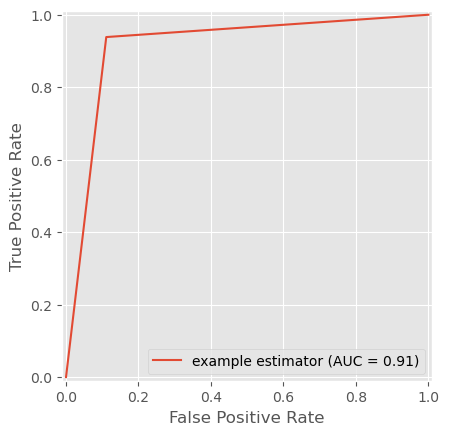

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')

display.plot()
plt.show()

Finalmente, podemos observar que el modelo tiene un AUC de 0.91 utilizando los datos de prueba, lo que indica que está bien entrenado. Sin embargo, si se exploran más hiperparámetros en el modelo, podría ser posible encontrar una configuración con métricas de rendimiento aún mejores.

## Conclusion

En conclusión, luego de realizar el procesamiento y balanceo de los datos, se entrenaron y evaluaron varios modelos de clasificación para la tarea de predicción de problemas en procesos de un servidor. El modelo de Regresión Logística, tras ser optimizado mediante GridSearchCV, demostró ser el más efectivo, alcanzando un AUC de 0.91 en los datos de prueba. La matriz de confusión validó que las predicciones fueron mayoritariamente correctas, confirmando el buen desempeño del modelo. Aunque el modelo actual ya muestra un rendimiento sólido, la búsqueda adicional de hiperparámetros podría permitir la mejora de sus métricas. En general, los resultados sugieren que el modelo es adecuado para la tarea de clasificación, pero existen oportunidades para seguir perfeccionándolo.